Step1- Image Acquisition

In [1]:
"""#Classical Computer Vision Pipeline for Face Recognition
#Capture → Clean → Segment → Extract → Match → Recognize → Refine

import cv2
# Option 1: Acquire from webcam (real-time)
cap = cv2.VideoCapture(0)  # 0 = default camera
ret, frame = cap.read()    # Capture a frame
if ret:
    cv2.imwrite('pac (1).jpg', frame)  # Save for next steps
cap.release()

# Option 2: Load from file (simulated acquisition)
# frame = cv2.imread('input.jpg')  # Use this if no camera
cv2.imshow('Acquired Image', frame)
cv2.waitKey(0)
cv2.destroyAllWindows()
"""


"#Classical Computer Vision Pipeline for Face Recognition\n#Capture → Clean → Segment → Extract → Match → Recognize → Refine\n\nimport cv2\n# Option 1: Acquire from webcam (real-time)\ncap = cv2.VideoCapture(0)  # 0 = default camera\nret, frame = cap.read()    # Capture a frame\nif ret:\n    cv2.imwrite('pac (1).jpg', frame)  # Save for next steps\ncap.release()\n\n# Option 2: Load from file (simulated acquisition)\n# frame = cv2.imread('input.jpg')  # Use this if no camera\ncv2.imshow('Acquired Image', frame)\ncv2.waitKey(0)\ncv2.destroyAllWindows()\n"

In [2]:
#Classical Computer Vision Pipeline for Face Recognition
#Capture → Clean → Segment → Extract → Match → Recognize → Refine

import cv2
# Option 1: Acquire from webcam (real-time)
frame = cv2.imread('face.jpg')

# Option 2: Load from file (simulated acquisition)
# frame = cv2.imread('input.jpg')  # Use this if no camera
cv2.imshow('Acquired Image', frame)
cv2.waitKey(0)
cv2.destroyAllWindows()



Step-2 Pre Processing

In [3]:
import cv2

cap = cv2.VideoCapture(0)
ret, frame = cap.read()
if not ret:
    raise RuntimeError("Failed to capture frame from camera")

cv2.imwrite("acquired_image.jpg", frame)  # Make sure this succeeds
cap.release()

In [4]:
import cv2
img = cv2.imread('acquired_image.jpg')
#Enhance image for better feature extraction
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Grayscale
blur = cv2.GaussianBlur(gray, (5,5), 0)       # Denoise
equalized = cv2.equalizeHist(blur)            # Contrast enhancement
cv2.imshow('Preprocessed', equalized)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imwrite('preprocessed.jpg', equalized)    # Save for next

True

Step3 - REGION OF INTEREST(ROI) / SEGMENTATION

In [5]:
import cv2
img = cv2.imread('preprocessed.jpg', 0)
#Separate foreground (face) from background
_, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)  # Binary segmentation
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
output = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
cv2.drawContours(output, contours, -1, (0,255,0), 2)  # Draw segmented regions

cv2.imshow('Segmented', output)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imwrite('segmented.jpg', output)

True

Step4 - FEATURE EXTRACTION

In [6]:
import cv2
img = cv2.imread('segmented.jpg', 0)
orb = cv2.ORB_create()
#Describe important points
keypoints, descriptors = orb.detectAndCompute(img, None)  # Extract features
output = cv2.drawKeypoints(img, keypoints, None, color=(0,255,0))
cv2.imshow('Features', output)
cv2.waitKey(0)
cv2.destroyAllWindows()
# Descriptors are arrays; save keypoints if needed

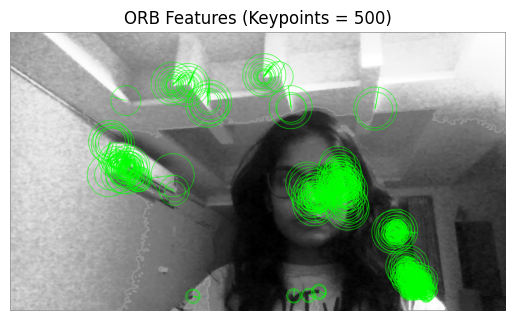

In [7]:
import cv2
import matplotlib.pyplot as plt

# Read image (grayscale)
img = cv2.imread('segmented.jpg', 0)

# ORB feature detector
orb = cv2.ORB_create()
keypoints, descriptors = orb.detectAndCompute(img, None)

# Draw keypoints (green)
output = cv2.drawKeypoints(
    img,
    keypoints,
    None,
    color=(0, 255, 0),
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

# Convert BGR → RGB for matplotlib
output_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

# Display using matplotlib
plt.imshow(output_rgb)
plt.title(f"ORB Features (Keypoints = {len(keypoints)})")
plt.axis("off")
plt.show()

Step5 - FEATURE MATCHING

In [8]:
import numpy as np
import os

img1 = cv2.imread('segmented.jpg', 0)
img2 = cv2.imread('preprocessed.jpg', 0)

if img1 is None:
    raise IOError("segmented.jpg not found or cannot be read")
if img2 is None:
    raise IOError("another_image.jpg not found or cannot be read")

orb = cv2.ORB_create()

kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

# Check descriptors
if des1 is None or des2 is None:
    raise ValueError(
        f"No descriptors found: des1={des1 is None}, des2={des2 is None}. "
        "Try different images or ORB parameters."
    )

print("des1 shape:", des1.shape, "dtype:", des1.dtype)
print("des2 shape:", des2.shape, "dtype:", des2.dtype)

if des1.dtype != des2.dtype or des1.shape[1] != des2.shape[1]:
    raise ValueError("Descriptor types or dimensions do not match")

#Connect same object between two images. It compares descriptor A with B and finds the closest match
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)

matches = sorted(matches, key=lambda x: x.distance)
output = cv2.drawMatches(img1, kp1, img2, kp2, matches[:50], None)

cv2.imshow('Matches', output)
cv2.waitKey(0)
cv2.destroyAllWindows()

des1 shape: (500, 32) dtype: uint8
des2 shape: (500, 32) dtype: uint8


Step 6 -Classification / Recognition

In [9]:
img_path = "segmented.jpg"
if not os.path.exists(img_path):
    raise FileNotFoundError(f"{img_path} not found")

img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
if img is None:
    raise IOError(f"Failed to read {img_path}")

# Find contours on a binary mask (segmented.jpg)
contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

output = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

min_area = 50      
large_thresh = 1000  # if area > large_thresh → "Large", else "Small"

for i, cnt in enumerate(contours):
    area = cv2.contourArea(cnt)
    if area < min_area:
        continue   

    # Compute bounding box for more stable label placement
    x, y, w, h = cv2.boundingRect(cnt)

    label_cls = "Large" if area > large_thresh else "Small"
    label = f"{label_cls}, A={int(area)}"

    # Draw contour
    cv2.drawContours(output, [cnt], -1, (0, 255, 0), 2)
    # Draw bounding box
    cv2.rectangle(output, (x, y), (x + w, y + h), (0, 0, 255), 1)
    # Put label above the box
    cv2.putText(output, label, (x, max(y - 5, 0)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

print(f"Kept {len(contours)} contours (before area filter).")

cv2.imshow("Classified", output)
cv2.waitKey(0)
cv2.destroyAllWindows()

Kept 1 contours (before area filter).


Step7 - Feature Detection

In [10]:
# Example detections: [x, y, w, h, confidence]
detections = np.array([
    [100, 100, 50, 50, 0.9],
    [105, 105, 50, 50, 0.8]
])

# Apply Non-Maximum Suppression
boxes = detections[:, :4].tolist()
scores = detections[:, 4].tolist()

indices = cv2.dnn.NMSBoxes(boxes, scores, score_threshold=0.5, nms_threshold=0.4) #Remove duplicate detections, if multiple boxes overlap then  keep strongest

# Load image safely
img = cv2.imread('segmented.jpg')
if img is None:
    raise FileNotFoundError("segmented.jpg not found.")

# Draw bounding boxes after NMS
if len(indices) > 0:
    for i in indices.flatten():  # Flatten ensures correct indexing
        x, y, w, h = detections[i, :4].astype(int)
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

print(f"Detected objects after NMS: {len(indices)}")

cv2.imshow('Post-processed Output', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

Detected objects after NMS: 1


In [11]:
# Load Haar Cascades
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'    #Use trained model for face and eyes detection, etc. These XML files contain pre-trained classifiers for various objects, including faces and eyes.
)

eye_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + 'haarcascade_eye.xml'
)

# Use webcam (change to image path if needed)
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    raise RuntimeError("Cannot access camera.")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30)
    )

    for (x, y, w, h) in faces:
        # Draw face rectangle
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

        roi_gray = gray[y:y + h, x:x + w]
        roi_color = frame[y:y + h, x:x + w]

        # Detect eyes inside face ROI
        eyes = eye_cascade.detectMultiScale(roi_gray)

        for (ex, ey, ew, eh) in eyes:
            cv2.rectangle(
                roi_color,
                (ex, ey),
                (ex + ew, ey + eh),
                (0, 255, 0),
                1
            )

    cv2.imshow('Classical Face + Eye Detection', frame)

    # Exit on pressing 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()